In [123]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

# Naive Bayes Classifier for Determining Whether a Song is Explicit

Our goal is to create a Naive Bayes Classifier model for determining whether a song is explicit given its lyrics. Our data was obtained using the Musixmatch API. 

We got the top chart songs from several English speaking countries. Then, we got the lyrics for each of those songs and whether the song is explicit. We then wrote that data to a .csv file.

## Data Preparation

First, we read in the data. Then, we stem it and remove stop words to make things more simple for our classifier.

In [124]:
tracks = pd.read_csv("data/tracks.csv",index_col=0)
tracks.dropna(inplace=True)
tracks.reset_index(inplace=True)
del tracks["index"]

# Stemming words and removing stop words
nltk.download('stopwords')
stopWords = stopwords.words('english')
stemmer = PorterStemmer()

# Function to stem lyrics
def stemLyrics(stop_words):
    stemmedLyricsList = []
    for lyrics in tracks['lyrics']:
        lyricsList = lyrics.split(" ")
        stemmedLyrics = [stemmer.stem(word) for word in lyricsList if word.lower() not in stop_words]
        stemmedLyrics = ' '.join(stemmedLyrics)
        stemmedLyricsList.append(stemmedLyrics)
    return stemmedLyricsList

stemmedLyrics = stemLyrics(stopWords)
tracks = tracks.assign(stemmed_lyrics=stemmedLyrics)
tracks

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\drewz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,lyrics,explicit,stemmed_lyrics
0,272451645,"For a while there, it was rough\nBut lately, I...",0,"there, rough\nbut lately, i'v doin' better\nth..."
1,275242628,This ain't Texas (ooh)\nAin't no hold 'em (hey...,1,ain't texa (ooh)\nain't hold 'em (hey)\nso lay...
2,276929882,I always wake up in the deep end\nWhy do I do ...,0,alway wake deep end\nwhi everi weekend?\ni gue...
3,258292930,"Something's got a hold of me lately\nNo, I don...",0,"something' got hold lately\nno, know anymore\n..."
4,277189732,"I am not Republican, I am not a Liberal\nWhy t...",1,"republican, liberal\nwhi hell can't american w..."
...,...,...,...,...
392,277509246,Твоей тупизне нет предела\nПасть лучше закрой\...,1,твоей тупизне нет предела\nпасть лучше закрой\...
393,236196962,I can still remember me and Miss November Rain...,0,still rememb miss novemb rain\nbeauti strange\...
394,276902997,Tell me the words I've forgotten\nWhat we were...,0,tell word i'v forgotten\nwhat fight for\nstar ...
395,261256425,I was sweet 'til you left me on my knees\nTook...,1,"sweet 'til left knees\ntook honey, made b (bad..."


## Define Input Features and Output Classes

Next, we define our input features and output classes. This will be our stemmed lyrics and the explicit flag for each song.

In [125]:
# Define Input Features and Output Classes
X = tracks['stemmed_lyrics']
y = tracks['explicit']

Now, we make a function for our Naive Bayes Classifier

In [126]:
# Naive Bayes Classifier Function

def naive_bayes(X,y, printMetrics=True, showConfusionMatrix=False):
    # Getting training and testing X and y
    # Convert text to numerical features
    vectorizer = CountVectorizer()
    Xvec = vectorizer.fit_transform(X)

    # Split into training and testing
    trainX, testX, trainY, testY = train_test_split(Xvec,y)

    # Train the classifier
    classifier = MultinomialNB()
    classifier.fit(trainX,trainY)

    # Predict the test data
    predictY = classifier.predict(testX)

    # Get metrics for classifier (precision, recall, fscore, support)
    metrics = {}
    p,r,f,s = precision_recall_fscore_support(testY,predictY)

    metrics["precision"] = p
    metrics["recall"] = r
    metrics["f-score"] = f
    metrics["support"] = s

    if printMetrics:
        for metric in metrics.keys():
            print(f"{metric}: {metrics[metric]}")

    # Plot confusion matrix
    if showConfusionMatrix:
        labels = ["Not Explicit", "Explicit"]
        confusionMatrix = confusion_matrix(predictY,testY)
        display = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=labels)
        display.plot()

    return classifier, metrics

Run the function to obtain the classifier and the metrics

precision: [0.84848485 0.70588235]
recall: [0.84848485 0.70588235]
f-score: [0.84848485 0.70588235]
support: [66 34]


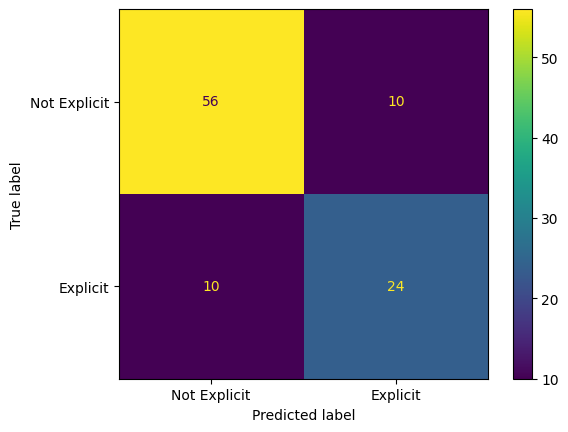

In [127]:
# Run naive bayes function
classifier, metrics = naive_bayes(X,y,showConfusionMatrix=True)

## Cross-Validation

To see how well our classifier performs, use 10-fold cross validation:

In [128]:
# Function which does k-fold cross validation
def kFoldCrossValidation(X,y,kValue):
    kfold = KFold(kValue,shuffle=True)
    metrics_averages = {"precision": 0, "recall": 0, "f-score": 0, "support": 0}
    for train, test in kfold.split(X,y):
        classifier, metrics = naive_bayes(X,y,printMetrics=False)
        for metric in metrics.keys():
            metrics_averages[metric] += metrics[metric]
    for metric in metrics_averages.keys():
        metrics_averages[metric] = metrics_averages[metric]/kValue

    for metric in metrics.keys():
        print(f"average {metric}: {metrics_averages[metric]}")
    return metrics_averages

metrics_averages = kFoldCrossValidation(X,y,10)

average precision: [0.85027988 0.81427388]
average recall: [0.9110725  0.70333614]
average f-score: [0.8794082  0.75380204]
average support: [65.1 34.9]


# Prediction of Explicit without "Bad Words"

Can a naive bayes classifier predict whether a song is explicit without being supplied the "bad words" in a song?

First, we add "bad words" to stop words. Then, supply new stemmed data to naive bayes.

In [129]:
# Add bad words to stop words
badWords = ['bitch','fuck','shit','dick', 'ass', 'pussy']
for word in badWords:
    stopWords.append(word)
# Use stemLyrics function defined earlier
# To filter stop words and stem lyrics
stemmedLyrics = stemLyrics(stopWords)
tracks = tracks.assign(stemmed_no_swears=stemmedLyrics)
tracks

,id,lyrics,explicit,stemmed_lyrics,stemmed_no_swears
0,272451645,"For a while there, it was rough\nBut lately, I...",0,"there, rough\nbut lately, i'v doin' better\nth...","there, rough\nbut lately, i'v doin' better\nth..."
1,275242628,This ain't Texas (ooh)\nAin't no hold 'em (hey...,1,ain't texa (ooh)\nain't hold 'em (hey)\nso lay...,ain't texa (ooh)\nain't hold 'em (hey)\nso lay...
2,276929882,I always wake up in the deep end\nWhy do I do ...,0,alway wake deep end\nwhi everi weekend?\ni gue...,alway wake deep end\nwhi everi weekend?\ni gue...
3,258292930,"Something's got a hold of me lately\nNo, I don...",0,"something' got hold lately\nno, know anymore\n...","something' got hold lately\nno, know anymore\n..."
4,277189732,"I am not Republican, I am not a Liberal\nWhy t...",1,"republican, liberal\nwhi hell can't american w...","republican, liberal\nwhi hell can't american w..."
...,...,...,...,...,...
392,277509246,Твоей тупизне нет предела\nПасть лучше закрой\...,1,твоей тупизне нет предела\nпасть лучше закрой\...,твоей тупизне нет предела\nпасть лучше закрой\...
393,236196962,I can still remember me and Miss November Rain...,0,still rememb miss novemb rain\nbeauti strange\...,still rememb miss novemb rain\nbeauti strange\...
394,276902997,Tell me the words I've forgotten\nWhat we were...,0,tell word i'v forgotten\nwhat fight for\nstar ...,tell word i'v forgotten\nwhat fight for\nstar ...
395,261256425,I was sweet 'til you left me on my knees\nTook...,1,"sweet 'til left knees\ntook honey, made b (bad...","sweet 'til left knees\ntook honey, made b (bad..."


Define input and output:

In [130]:
# Define X and y:
X = tracks['stemmed_no_swears']
y = tracks['explicit']

Supply to naive bayes:

precision: [0.82857143 0.9       ]
recall: [0.95081967 0.69230769]
f-score: [0.88549618 0.7826087 ]
support: [61 39]


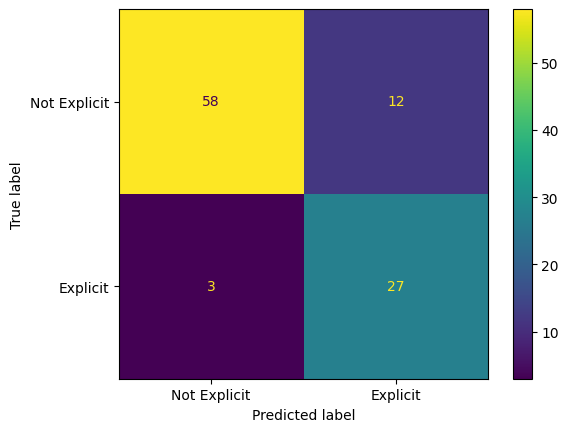

In [131]:
classifier, metrics = naive_bayes(X,y,printMetrics=True, showConfusionMatrix=True)

Now, use 10 fold cross validation to see how our model did:

In [132]:
metrics_averages = kFoldCrossValidation(X,y,10)

average precision: [0.87316492 0.82259057]
average recall: [0.91457716 0.73917302]
average f-score: [0.89205151 0.77327922]
average support: [66. 34.]
